In [1]:
%matplotlib inline
from collections import defaultdict
import json

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl

#colorbrewer2 Dark2 qualitative color table
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'


def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
#this mapping between states and abbreviations will come in handy later
states_abbrev = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [7]:
#adapted from  https://github.com/dataiap/dataiap/blob/master/resources/util/map_util.py

#load in state geometry
state2poly = defaultdict(list)

with open('./data/us-states.json') as json_data:
    data = json.load(json_data)
#data = json.load(file("./data/us-states.json"))
for f in data['features']:
    state = states_abbrev[f['id']]
    geo = f['geometry']
    if geo['type'] == 'Polygon':
        for coords in geo['coordinates']:
            state2poly[state].append(coords)
    elif geo['type'] == 'MultiPolygon':
        for polygon in geo['coordinates']:
            state2poly[state].extend(polygon)

            
def draw_state(plot, stateid, **kwargs):
    """
    draw_state(plot, stateid, color=..., **kwargs)
    
    Automatically draws a filled shape representing the state in
    subplot.
    The color keyword argument specifies the fill color.  It accepts keyword
    arguments that plot() accepts
    """
    for polygon in state2poly[stateid]:
        xs, ys = zip(*polygon)
        plot.fill(xs, ys, **kwargs)

        
def make_map(states, label):
    """
    Draw a cloropleth map, that maps data onto the United States
    
    Inputs
    -------
    states : Column of a DataFrame
        The value for each state, to display on a map
    label : str
        Label of the color bar

    Returns
    --------
    The map
    """
    fig = plt.figure(figsize=(12, 9))
    ax = plt.gca()

    if states.max() < 2: # colormap for election probabilities 
        cmap = cm.RdBu
        vmin, vmax = 0, 1
    else:  # colormap for electoral votes
        cmap = cm.binary
        vmin, vmax = 0, states.max()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    
    skip = set(['National', 'District of Columbia', 'Guam', 'Puerto Rico',
                'Virgin Islands', 'American Samoa', 'Northern Mariana Islands'])
    for state in states_abbrev.values():
        if state in skip:
            continue
        color = cmap(norm(states.ix[state]))
        draw_state(ax, state, color = color, ec='k')

    #add an inset colorbar
    ax1 = fig.add_axes([0.45, 0.70, 0.4, 0.02])    
    cb1=mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                  norm=norm,
                                  orientation='horizontal')
    ax1.set_title(label)
    remove_border(ax, left=False, bottom=False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-180, -60)
    ax.set_ylim(15, 75)
    return ax

In [8]:
# We are pretending to build our model 1 month before the election
import datetime
today = datetime.datetime(2012, 10, 2)
today

datetime.datetime(2012, 10, 2, 0, 0)

In [9]:
electoral_votes = pd.read_csv("data/electoral_votes.csv").set_index('State')
electoral_votes.head()

,Votes
State,
California,55
Texas,38
New York,29
Florida,29
Illinois,20


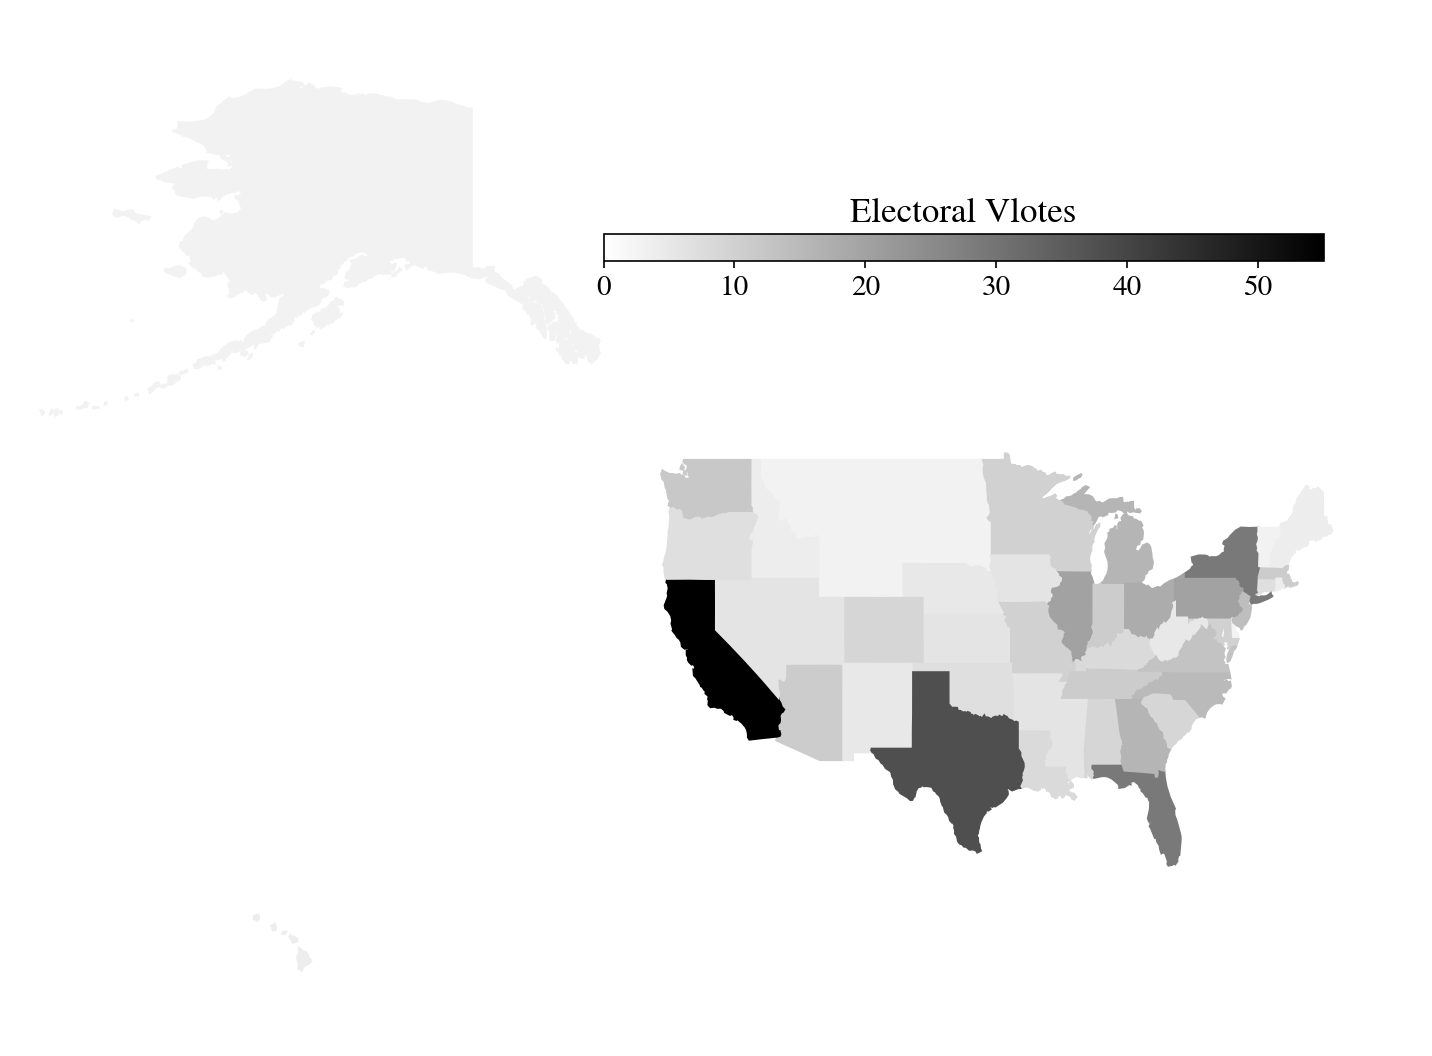

In [10]:
make_map(electoral_votes.Votes, "Electoral Vlotes");

In [11]:
predictwise = pd.read_csv('data/predictwise.csv').set_index('States')
predictwise.head()

,Obama,Romney,Votes
States,,,
Alabama,0.000,1.000,9
Alaska,0.000,1.000,3
Arizona,0.062,0.938,11
Arkansas,0.000,1.000,6
California,1.000,0.000,55


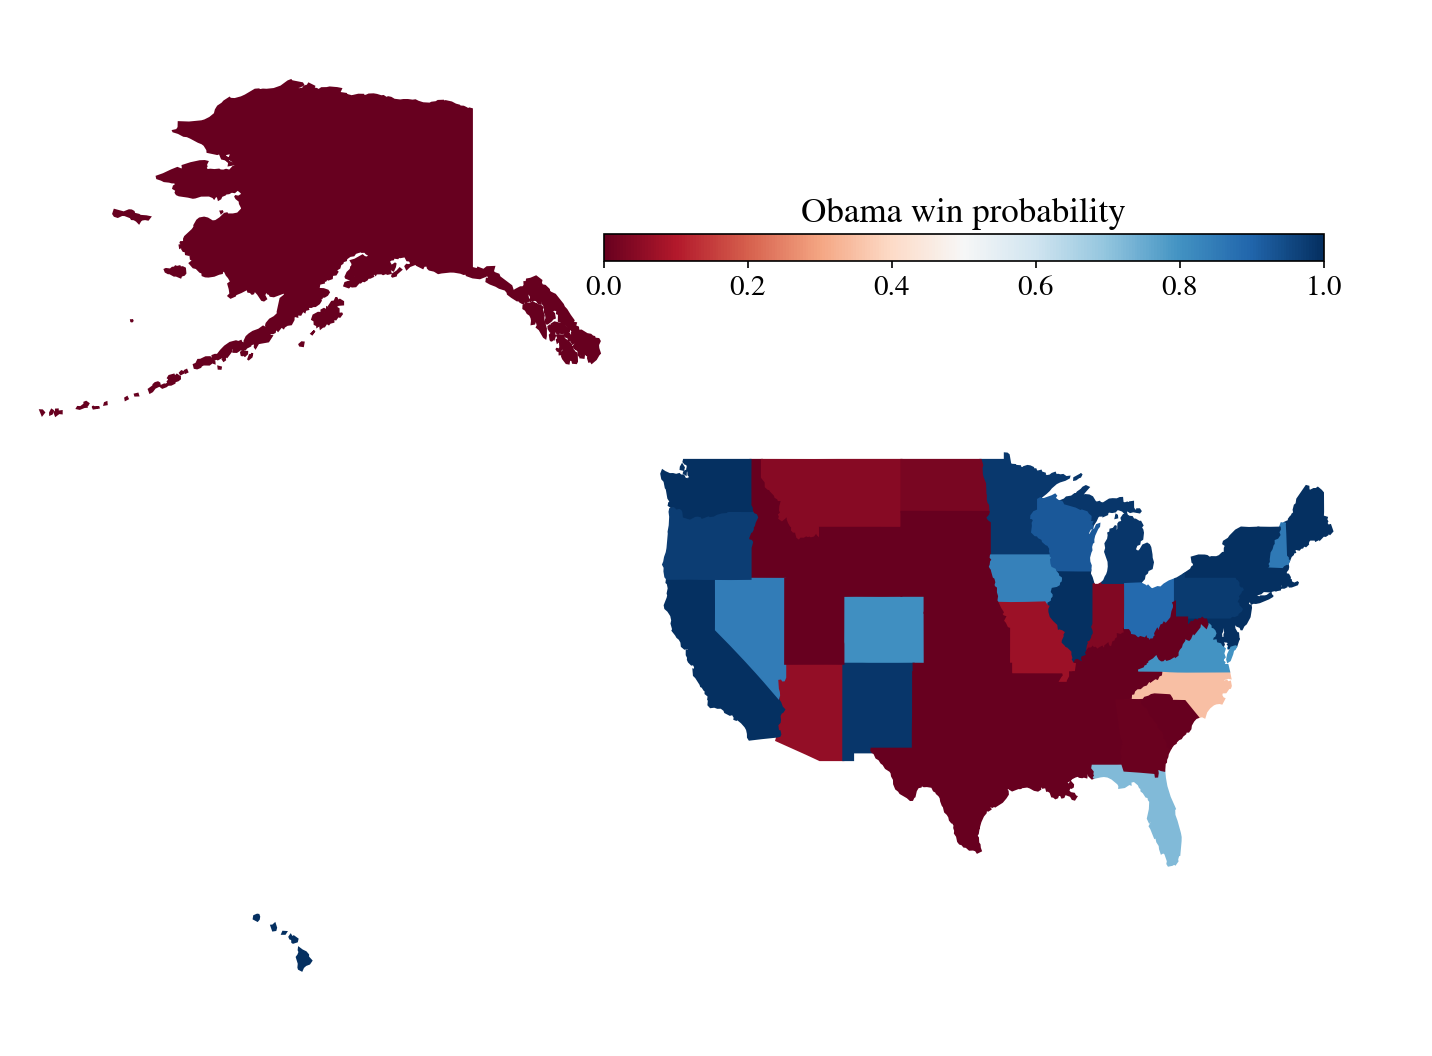

In [12]:
make_map(predictwise.Obama, "Obama win probability");

In [16]:
def simulate_election(model, n_sim):
    #each column simulates a single outcome from the 50 states + DC
    #Obama wins the simulation if the random number is < the win probability
    simulations = np.random.uniform(size=(51, n_sim))
    obama_votes = (simulations < model.Obama.values.reshape(-1, 1)) * model.Votes.values.reshape(-1, 1)
    #summing over rows gives the total electoral votes for each simulation
    return obama_votes.sum(axis=0)

In [17]:
result = simulate_election(predictwise, 10000)